In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Pablo\AppData\Local\Temp\ipykernel_32672\822149826.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [8]:
# create the data
num_samples_per_cluster = 200

th = np.linspace(0, 4 * np.pi, num_samples_per_cluster)
r1 = 10
r2 = 15

a = [r1*np.cos(th) + np.random.normal(0, 1, num_samples_per_cluster)*3,
     r1*np.sin(th) + np.random.normal(0, 1, num_samples_per_cluster)]

b = [r2*np.cos(th) + np.random.normal(0, 1, num_samples_per_cluster),
     r2*np.sin(th) + np.random.normal(0, 1, num_samples_per_cluster)*3]

data_np = np.concatenate([a, b], axis=1).T
data = torch.tensor(data_np, dtype=torch.float32)

labels_a = np.zeros(num_samples_per_cluster)
labels_b = np.ones(num_samples_per_cluster)
labels_np = np.concatenate([labels_a, labels_b])
labels = torch.tensor(labels_np, dtype=torch.float32).unsqueeze(1) # unsqueeze to make it a column vector

Text(0.5, 1.0, 'Two Clusters of Data')

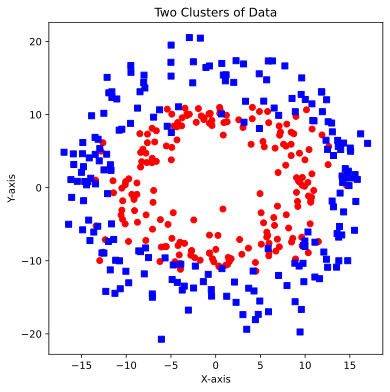

In [7]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data_np[:num_samples_per_cluster, 0], data_np[:num_samples_per_cluster, 1], 'ro', label='Cluster A')
plt.plot(data_np[num_samples_per_cluster:, 0], data_np[num_samples_per_cluster:, 1], 'bs', label='Cluster B')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Clusters of Data')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batchsize = 16
train_dataset = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False) # load all

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        self.dr = dropout_rate

    def forward(self, x):
        x = F.relu(self.input(x)) 
        x = F.dropout(x, p=self.dr, training=self.training) # apply dropout only during training
        x= F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training) # apply dropout only during training
        x = self.output(x)
        return x

In [15]:
def create_model(dropout_rate):
    
    model = SimpleNN(dropout_rate)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

    return model, loss_fn, optimizer

def train_model(model, loss_fn, optimizer, train_dataset, test_dataset, num_epochs):
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        model.train() # switch to training mode to enable dropout
        batch_acc = []
        for X_batch, y_batch in train_dataset:

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accuracy_batch = ((y_pred > 0.5) == y_batch).float().mean().item()
            batch_acc.append(accuracy_batch)

        train_acc.append(np.mean(batch_acc)) # mean accuracy for the epoch

        # test accuracy
        model.eval() # switch to evaluation mode to disable dropout
        X_test, y_test = next(iter(test_dataset)) # load all test data in one batch
        y_test_pred = model(X_test)
        test_accuracy = ((y_test_pred > 0.5) == y_test).float().mean().item()
        test_acc.append(test_accuracy)

    return train_acc, test_acc

In [20]:
 # Test on single model
dropout_rate = 0.0
num_epochs = 1000
model, loss_fn, optimizer = create_model(dropout_rate)
train_acc, test_acc = train_model(model, loss_fn, optimizer, train_dataset, test_dataset, num_epochs)

def smooth(x, k=5):
    # simple moving average to smooth the training loss curve for better visualization
    return np.convolve(x, np.ones(k)/k, mode='valid')

Text(0.5, 1.0, 'Dropout Rate: 0.0')

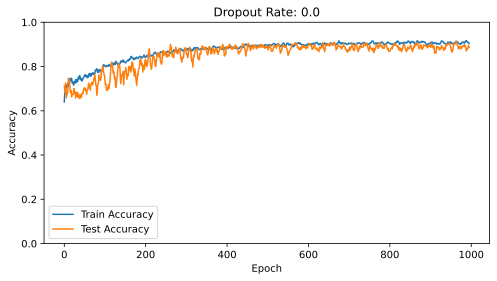

In [22]:
fig = plt.figure(figsize=(8, 4))
plt.plot(smooth(train_acc), label='Train Accuracy')
plt.plot(smooth(test_acc), label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.title(f"Dropout Rate: {dropout_rate}")

In [23]:
# Run experiment
dropout_rates = np.arange(10) / 10
results = np.zeros((len(dropout_rates), 2)) # to store train and test accuracies for each dropout rate

for i, dr in enumerate(dropout_rates):
    model, loss_fn, optimizer = create_model(dr)
    train_acc, test_acc = train_model(model, loss_fn, optimizer, train_dataset, test_dataset, num_epochs)
    results[i] = [np.mean(train_acc[-100:]), np.mean(test_acc[-100:])] # take the mean of the last 100 epochs to get a stable estimate of final accuracy

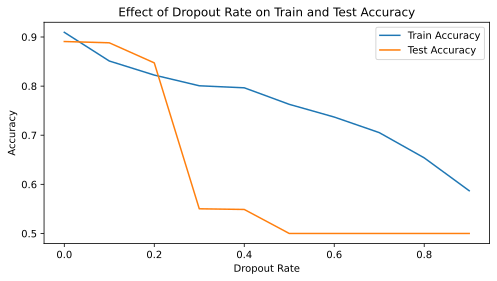

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(dropout_rates, results[:, 0], label='Train Accuracy')
ax.plot(dropout_rates, results[:, 1], label='Test Accuracy')
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Dropout Rate on Train and Test Accuracy')
ax.legend()

# We can see that dropout or regularization in general is not always beneficial. In this case,
#  the model is simple and the dataset is small, so it can easily overfit without dropout. 
# However, as we increase the dropout rate, the model's capacity to fit the training data decreases, 
# leading to worse performance on both train and test sets. This illustrates that regularization techniques 
# like dropout should be used judiciously based on the complexity of the model and the size of the dataset.